In [ ]:
'''
The DistilBert model is selectd after rigorious testing of other models such as
Random Forest, SVM, Naive Bayes, Logistic Regression, and K-Nearest Neighbors, gradient boosting and more.
None of the models performed over 75% test acuracy.

Afterwards transferleraning NLP models were experimented with where BERT ahieved 77% and RoBERT got 81%.

Then upon using Distil Bert and fine tuning, test accuracy rose to 87%.

'''


'''
#some findings

previously stemming was applied to the dataset but afterwaards it was removed as it did not improve DistilBERT performaance.

Also with stop words deleted dataset, the accuracy was 2-4% lower than normal dataset, this kind of indicates majority of the
deleted stop words were important for DistilBERT to better generalize the data.

Also deleting common words decreased the performance as majority  of the common words might contribute to the contextual
understanding of the model.
'''

In [6]:



from datasets import Dataset
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os



# mapping values to category names/class labels for the model to understand classes
label_map = {
    'AGRICULTURE': 0, 'SALES': 1, 'ACCOUNTANT': 2, 'AVIATION': 3, 'BANKING': 4, 'CONSULTANT': 5, 'FINANCE': 6, 'PUBLIC-RELATIONS': 7,
    'BUSINESS-DEVELOPMENT': 8, 'CHEF': 9, 'AUTOMOBILE': 10, 'INFORMATION-TECHNOLOGY': 11, 'DIGITAL-MEDIA': 12, 'ENGINEERING': 13,
    'ARTS': 14, 'HR': 15, 'APPAREL': 16, 'HEALTHCARE': 17, 'FITNESS': 18, 'CONSTRUCTION': 19, 'TEACHER': 20, 'ADVOCATE': 21, 'BPO': 22, 'DESIGNER': 23
}


# Loadingthe datasets
train_set = pd.read_csv('/content/drive/MyDrive/data_/aug_train_dataset_clen7.csv')
test_set = pd.read_csv('/content/drive/MyDrive/data_/val_dataset_clen7.csv')

# Mapping categories to labels according to the redefined lable_map
train_set['label'] = train_set['category'].map(label_map)
test_set['label'] = test_set['category'].map(label_map)

# forcing the text samples to be string obj
train_set['resume'] = train_set['resume'].astype(str)
test_set['resume'] = test_set['resume'].astype(str)

# Converting dataframe object to dataset object
train_dataset = Dataset.from_pandas(train_set[['resume', 'label']])
test_dataset = Dataset.from_pandas(test_set[['resume', 'label']])

# loading existing DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# function to breaak down text to small tokens for the model to understand
def tokenizing(resume_str):
    return tokenizer(resume_str['resume'], padding='max_length', truncation=True)

# appplying tokenizer to datasets
train_dataset = train_dataset.map(tokenizing, batched=True)
test_dataset = test_dataset.map(tokenizing, batched=True)

# Set the format for PyTorch
train_dataset = train_dataset.rename_column('label', 'labels')
test_dataset = test_dataset.rename_column('label', 'labels')
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])


# creaating dataloader for batch training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Map:   0%|          | 0/2880 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

In [11]:


# setting up device (gpu) for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# initializing DistilBERT model with  24 classes
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=24)
model.to(device)# pushing model to gpu


# calculating class_weights from number of classes and sample count in classes.
# primarily used in imbalanced train dataset, in our case dataset is balanced due to augmentation.
Y_labels = train_set['label'].values
class_weights = torch.tensor([1.0 / count for count in np.bincount(Y_labels)], dtype=torch.float)
class_weights = class_weights.to(device)


epochs = 10# defining how maany iterations will the model will run

# defining optimizer loss function and sheduler
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss(weight=class_weights)# adding the previously calculated weight
num_train_steps = len(train_loader) * epochs# standard calculation fortrain_steps
#scheduler = StepLR(optimizer, step_size=10, gamma=0.7)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# defining veriables to store model matrics while training
train_losses = []
eval_losses = []
train_accuracies = []
eval_accuracies = []

# providing a path to save best model from the epoch having highest eval accuracy
model_save_path = "/content/drive/MyDrive/model/state_dict_model.pt"

# CSV file path for training matrics
metrics_csv_path = '/content/drive/MyDrive/csv/metrics.csv'
metrics_df = pd.DataFrame(columns=['Epoch', 'Train_loss', 'Val_loss', 'Train_acc', 'Val_acc'])


# initialize a
best_val_accuracy = 0.0


# traainin loop for model

for epoch in range(epochs):
    model.train()## setting thee model to train mode
    epoch_train_loss = 0
    correct_train_preds = 0
    total_train_preds = 0# initializing to calculate evaluation matrics while training

    for batch in train_loader:#iterating through data batch
        optimizer.zero_grad()# clearing previous modelparameter gradients
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device),
            'labels': batch['labels'].to(device)
            }# preparing inputs from batch

        outputs = model(**inputs)# forward pass
        loss = criterion(outputs.logits, inputs['labels'])#  caalculation train loss
        loss.backward()#baackward pass
        optimizer.step()# update gradient
        scheduler.step()# updating learning rate

        epoch_train_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct_train_preds += (preds == inputs['labels']).sum().item()# correct predictions in batch
        total_train_preds += inputs['labels'].size(0)# total samples in batch

    train_loss = epoch_train_loss / len(train_loader)# train loss from all batch average
    train_accuracy = correct_train_preds / total_train_preds# train acc from all batch average

    # evaluating the model on vaalidation set in each epoch
    model.eval()# setting the model to evaluate state
    epoch_eval_loss = 0
    correct_eval_preds = 0
    total_eval_preds = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'labels': batch['labels'].to(device)
            }
            outputs = model(**inputs)
            loss = criterion(outputs.logits, inputs['labels'])
            epoch_eval_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_eval_preds += (preds == inputs['labels']).sum().item()
            total_eval_preds += inputs['labels'].size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(inputs['labels'].cpu().numpy())

    eval_loss = epoch_eval_loss / len(test_loader)# average validation loss calculated from val set all batch
    eval_accuracy = correct_eval_preds / total_eval_preds# average validation acc calculated from val set all batch

    # printing evaluation metrics in eaach epoch to evaluate model performance
    print(f"Epoch__________________  {epoch + 1}")
    print(f"Train Loss: {train_loss}")
    print(f"Eval Loss: {eval_loss}")
    print(f"Train Acc: {train_accuracy}")
    print(f"Eval Acc: {eval_accuracy}")

    # push matrics to data frame
    metrics_df = pd.concat([metrics_df, pd.DataFrame([{
        'Epoch': epoch + 1,
        'Train_loss': train_loss,
        'Val_loss': eval_loss,
        'Train_acc': train_accuracy,
        'Val_acc': eval_accuracy}])],
        ignore_index=True)

    # saving dataframe as csv for plotting learning curves later
    metrics_df.to_csv(metrics_csv_path, index=False)


    if eval_accuracy > best_val_accuracy:    #checking if the current validation accuracy is the highest so far
        best_val_accuracy = eval_accuracy
        torch.save(model.state_dict(), model_save_path)# save .pt file if highest val acc.
        print(f"Save model_acc>>>>>>>>>>>>>>>> {eval_accuracy}")




Epoch__________________  1
Train Loss: 2.9992759042316015
Eval Loss: 2.521597825563871
Train Acc: 0.225
Eval Acc: 0.5025125628140703


<ipython-input-12-c8c7965ae331>:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([{


Save model_acc>>>>>>>>>>>>>>>> 0.5025125628140703
Epoch__________________  2
Train Loss: 2.0896508673826855
Eval Loss: 1.4965107074150672
Train Acc: 0.665625
Eval Acc: 0.8140703517587939
Save model_acc>>>>>>>>>>>>>>>> 0.8140703517587939
Epoch__________________  3
Train Loss: 1.2859415812624826
Eval Loss: 1.02514720421571
Train Acc: 0.8392361111111111
Eval Acc: 0.8592964824120602
Save model_acc>>>>>>>>>>>>>>>> 0.8592964824120602
Epoch__________________  4
Train Loss: 0.8500636529591349
Eval Loss: 0.8521910355641291
Train Acc: 0.8954861111111111
Eval Acc: 0.8442211055276382
Epoch__________________  5
Train Loss: 0.6116245716810227
Eval Loss: 0.7594935687688681
Train Acc: 0.9246527777777778
Eval Acc: 0.8592964824120602
Epoch__________________  6
Train Loss: 0.4803427518241935
Eval Loss: 0.6891893973717322
Train Acc: 0.940625
Eval Acc: 0.8743718592964824
Save model_acc>>>>>>>>>>>>>>>> 0.8743718592964824
Epoch__________________  7
Train Loss: 0.3959087736904621
Eval Loss: 0.6736287715343329

NameError: name 'labels' is not defined

In [14]:
#### generating confusion matrics and classification reports while evaluated on val set
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_map.keys()))


Confusion Matrix:
[[ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  1  0]
 [ 0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  0  0  0  1 12  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  3  0  0  0  0  5  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0

In [17]:


### evaluating the model on unseen test set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=24)
model.to(device)

#loading previously trained model weights to initialized model
model_path =  "/content/drive/MyDrive/model/state_dict_model.pt"### saved .pt file of best model
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# opening test dataset and processing for input as seen for train  set
test_set = pd.read_csv('/content/drive/MyDrive/job task/test_dataset_clen7.csv')
test_set['resume'] = test_set['resume'].astype(str)
test_set['label'] = test_set['category'].map(label_map)

test_dataset = Dataset.from_pandas(test_set[['resume', 'label']])
test_dataset = test_dataset.map(tokenizing, batched=True)
test_dataset = test_dataset.rename_column('label', 'labels')
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device),
            'labels': batch['labels'].to(device)
        }
        outputs = model(**inputs)
        logits = outputs[1]
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(inputs['labels'].cpu().numpy())

#### generating confusion matrics and classification reports while evaluated on val set
print("Confusion Matrix:")
conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_map.keys()))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-2029a7ab0515>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by 

Map:   0%|          | 0/497 [00:00<?, ? examples/s]

Confusion Matrix:
[[ 9  0  1  0  1  0  1  0  0  0  0  1  0  0  0  2  0  0  0  0  0  0  1  0]
 [ 0 20  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0 10  1  0  0  0  0  2  1  1  0  0  0  1  0  0  0  0  0  1  0]
 [ 0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 18  0  0  0  0  2  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  3  0  1  0  0  0  1  0  1  0  0  0  1  1]
 [ 0  0  0  0  0  0  0  0  0  0  0 18  2  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  1  0  0  0  0 16  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0

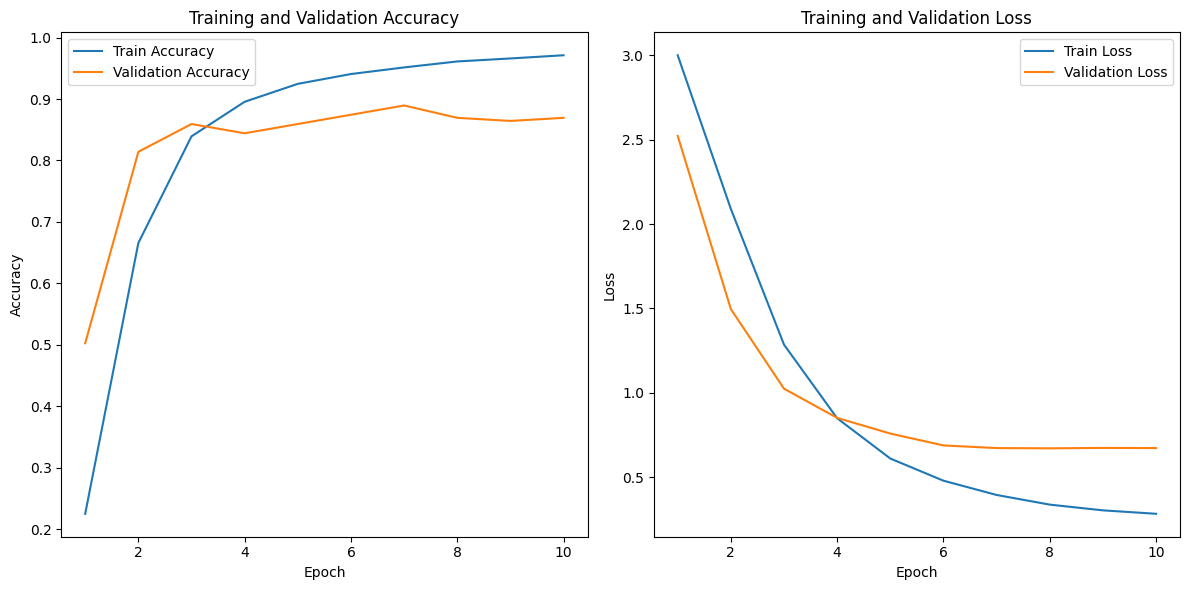

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/csv/metrics.csv'
df = pd.read_csv(file_path, sep='\t', header=None)

df = df[0].str.split(',', expand=True)
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)

df = df.astype({'Epoch': int, 'Train_loss': float, 'Val_loss': float, 'Train_acc': float, 'Val_acc': float})

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(df['Epoch'], df['Train_acc'], label='Train Accuracy')
plt.plot(df['Epoch'], df['Val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df['Epoch'], df['Train_loss'], label='Train Loss')
plt.plot(df['Epoch'], df['Val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
plt.savefig('/content/drive/MyDrive/csv/curve.png' ,bbox_inches='tight',dpi=300)

<Figure size 640x480 with 0 Axes>